In [2]:
import pandas as pd

# # Load the data to examine its structure
# file_path = 'data_daily.csv'
# data = pd.read_csv(file_path)
# data.head()

In [3]:
data = pd.read_csv('data_daily.csv', parse_dates=['# Date'])  

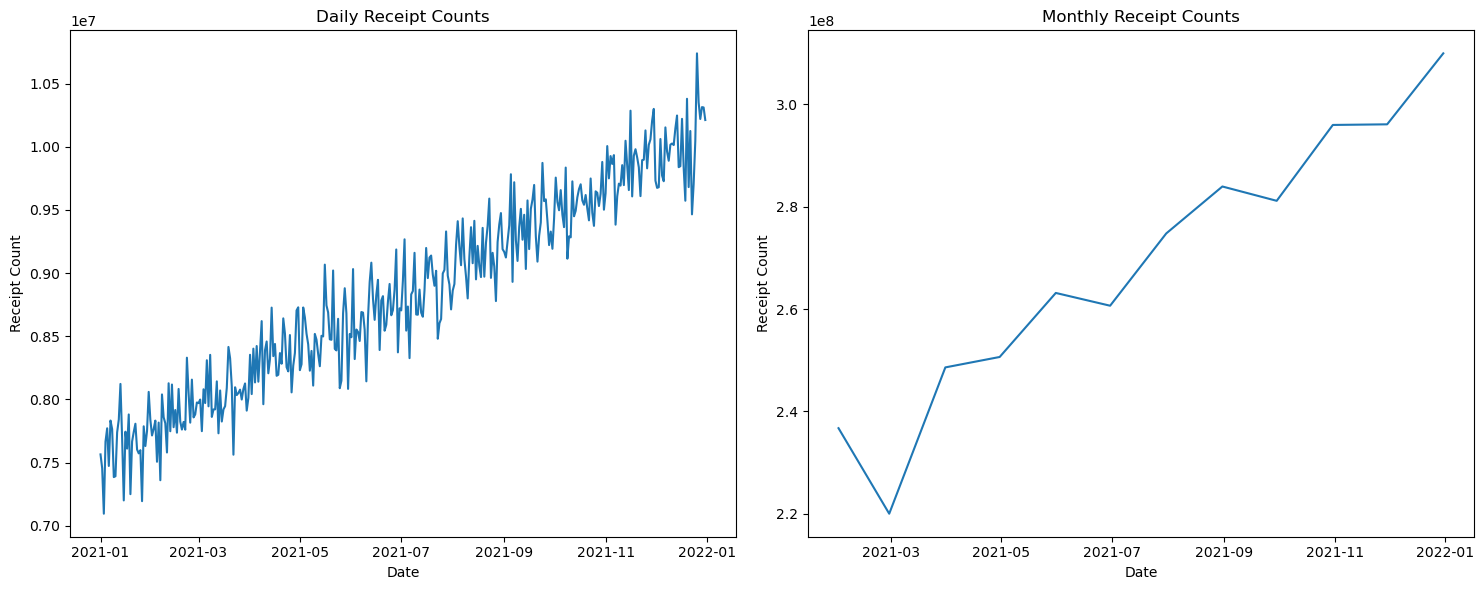

In [65]:
import matplotlib.pyplot as plt

# Data Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Resampling data to monthly frequency for EDA
monthly_data = data.resample('M').sum()

# Plotting the daily and monthly time series
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(data)
plt.title('Daily Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Receipt Count')

plt.subplot(1, 2, 2)
plt.plot(monthly_data)
plt.title('Monthly Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Receipt Count')

plt.tight_layout()
plt.show()

In [66]:
monthly_data

,Receipt_Count
Date,
2021-01-31,236736687
2021-02-28,220033460
2021-03-31,248608625
2021-04-30,250644830
2021-05-31,263151748
2021-06-30,260656840
2021-07-31,274776003
2021-08-31,283943231
2021-09-30,281146154


Daily Receipt Counts: There appears to be significant variability in the daily data, with possible patterns that could be weekly or bi-weekly.

Monthly Receipt Counts: The monthly data shows clearer trends and potential seasonality, which is important for forecasting monthly totals for 2022.

### Stationarity Check

In [67]:
from statsmodels.tsa.stattools import adfuller

# Performing Augmented Dickey-Fuller test to check for stationarity
adf_test = adfuller(monthly_data['Receipt_Count'])

# Output the results of the test
adf_result = {
    'ADF Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Number of Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4],
}

adf_result

{'ADF Test Statistic': -1.964535795201137,
 'p-value': 0.30233604074267784,
 'Number of Lags Used': 4,
 'Number of Observations Used': 7,
 'Critical Values': {'1%': -4.9386902332361515,
  '5%': -3.477582857142857,
  '10%': -2.8438679591836733}}

The ADF test statistic is not lower than any of the critical values at common significance levels (1%, 5%, and 10%). This implies that we cannot reject the null hypothesis of non-stationarity.

The p-value is greater than 0.05, further suggesting that the data is non-stationary.
Given these results, we need to transform the data to achieve stationarity before modeling. Common methods include differencing or applying a logarithmic transformation. Let's apply differencing and then retest for stationarity

In [68]:
# Differencing the data to achieve stationarity
monthly_data_diff = monthly_data.diff().dropna()

# Re-performing the Augmented Dickey-Fuller test on the differenced data
adf_test_diff = adfuller(monthly_data_diff['Receipt_Count'])

# Output the results of the test
adf_result_diff = {
    'ADF Test Statistic': adf_test_diff[0],
    'p-value': adf_test_diff[1],
    'Number of Lags Used': adf_test_diff[2],
    'Number of Observations Used': adf_test_diff[3],
    'Critical Values': adf_test_diff[4],
}

adf_result_diff

{'ADF Test Statistic': -3.366862225297939,
 'p-value': 0.01214176168041323,
 'Number of Lags Used': 3,
 'Number of Observations Used': 7,
 'Critical Values': {'1%': -4.9386902332361515,
  '5%': -3.477582857142857,
  '10%': -2.8438679591836733}}

In [69]:
from statsmodels.tsa.stattools import adfuller

# Performing the Augmented Dickey-Fuller test
adf_test = adfuller(monthly_data['Receipt_Count'])

# Extracting the p-value from the test results
adf_pvalue = adf_test[1]

adf_pvalue

0.30233604074267784

### Develop a time-series forecasting model.

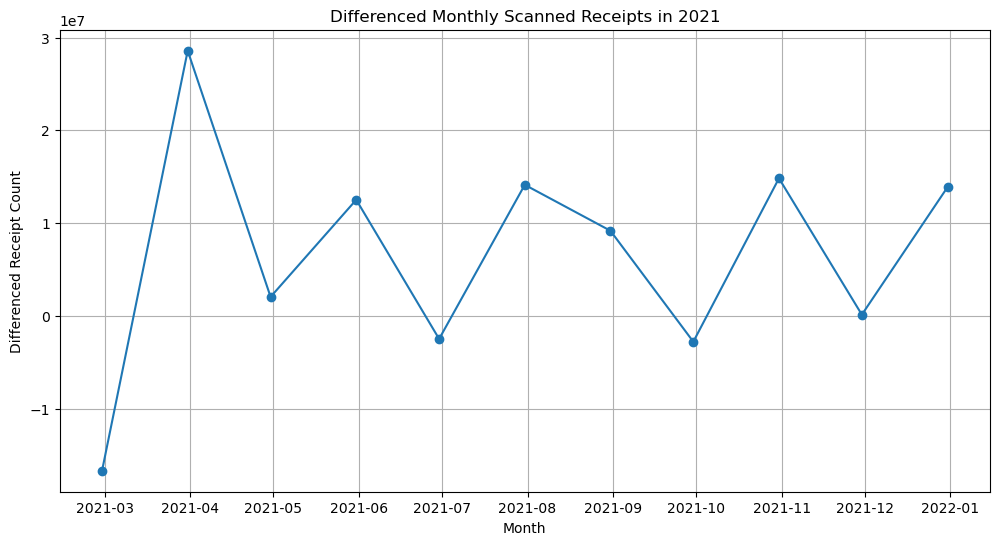

0.01214176168041323

In [70]:
# Applying first-order differencing
monthly_data_diff = monthly_data.diff().dropna()

# Re-performing the Augmented Dickey-Fuller test on the differenced data
adf_test_diff = adfuller(monthly_data_diff['Receipt_Count'])

# Extracting the p-value from the differenced data test results
adf_pvalue_diff = adf_test_diff[1]

# Plotting the differenced data
plt.figure(figsize=(12, 6))
plt.plot(monthly_data_diff.index, monthly_data_diff['Receipt_Count'], marker='o')
plt.title('Differenced Monthly Scanned Receipts in 2021')
plt.xlabel('Month')
plt.ylabel('Differenced Receipt Count')
plt.grid(True)
plt.show()

adf_pvalue_diff


In [71]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalizing the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data_diff)

# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Creating sequences with a given length
sequence_length = 3  # Number of months to use to predict the next month
X, y = create_sequences(scaled_data, sequence_length)

# Splitting the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6, 3, 1), (2, 3, 1), (6, 1), (2, 1))

In [72]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Function to calculate AIC for an ARIMA model
def calculate_aic(series, order):
    try:
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        return model_fit.aic
    except:
        return np.inf

# Setting the range of parameters to try for p, d, and q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

best_aic = np.inf
best_order = None

# Grid search for the best parameters
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            aic = calculate_aic(monthly_data['Receipt_Count'], order)
            if aic < best_aic:
                best_aic = aic
                best_order = order

best_order, best_aic

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\lib\site-packa

((2, 1, 1), 386.61800777506994)

In [73]:
# Train the ARIMA model with the best parameters
model = ARIMA(monthly_data['Receipt_Count'], order=best_order)
model_fit = model.fit()

# Forecasting for the next 12 months (2022)
forecast = model_fit.get_forecast(steps=12)
predicted_receipts = forecast.predicted_mean
predicted_receipts_ci = forecast.conf_int()

predicted_receipts

2022-01-31    3.114342e+08
2022-02-28    3.144559e+08
2022-03-31    3.166325e+08
2022-04-30    3.184904e+08
2022-05-31    3.200165e+08
2022-06-30    3.212804e+08
2022-07-31    3.223253e+08
2022-08-31    3.231895e+08
2022-09-30    3.239041e+08
2022-10-31    3.244951e+08
2022-11-30    3.249838e+08
2022-12-31    3.253880e+08
Freq: M, Name: predicted_mean, dtype: float64

In [74]:
predicted_receipts = predicted_receipts.reset_index()
predicted_receipts = pd.DataFrame(predicted_receipts)
predicted_receipts.columns = ['Date', 'Receipt_Count']
predicted_receipts

,Date,Receipt_Count
0,2022-01-31,3.114342e+08
1,2022-02-28,3.144559e+08
2,2022-03-31,3.166325e+08
3,2022-04-30,3.184904e+08
4,2022-05-31,3.200165e+08
5,2022-06-30,3.212804e+08
6,2022-07-31,3.223253e+08
7,2022-08-31,3.231895e+08
8,2022-09-30,3.239041e+08
9,2022-10-31,3.244951e+08


In [76]:
monthly_data=monthly_data.reset_index()

In [77]:
monthly_data

,Date,Receipt_Count
0,2021-01-31,236736687
1,2021-02-28,220033460
2,2021-03-31,248608625
3,2021-04-30,250644830
4,2021-05-31,263151748
5,2021-06-30,260656840
6,2021-07-31,274776003
7,2021-08-31,283943231
8,2021-09-30,281146154
9,2021-10-31,295965185


In [81]:
new_data = monthly_data.append(predicted_receipts)

C:\Users\Gliuh\AppData\Local\Temp\ipykernel_27072\3899346657.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = monthly_data.append(predicted_receipts)


In [82]:
new_data

,Date,Receipt_Count
0,2021-01-31,2.367367e+08
1,2021-02-28,2.200335e+08
2,2021-03-31,2.486086e+08
3,2021-04-30,2.506448e+08
4,2021-05-31,2.631517e+08
5,2021-06-30,2.606568e+08
6,2021-07-31,2.747760e+08
7,2021-08-31,2.839432e+08
8,2021-09-30,2.811462e+08
9,2021-10-31,2.959652e+08


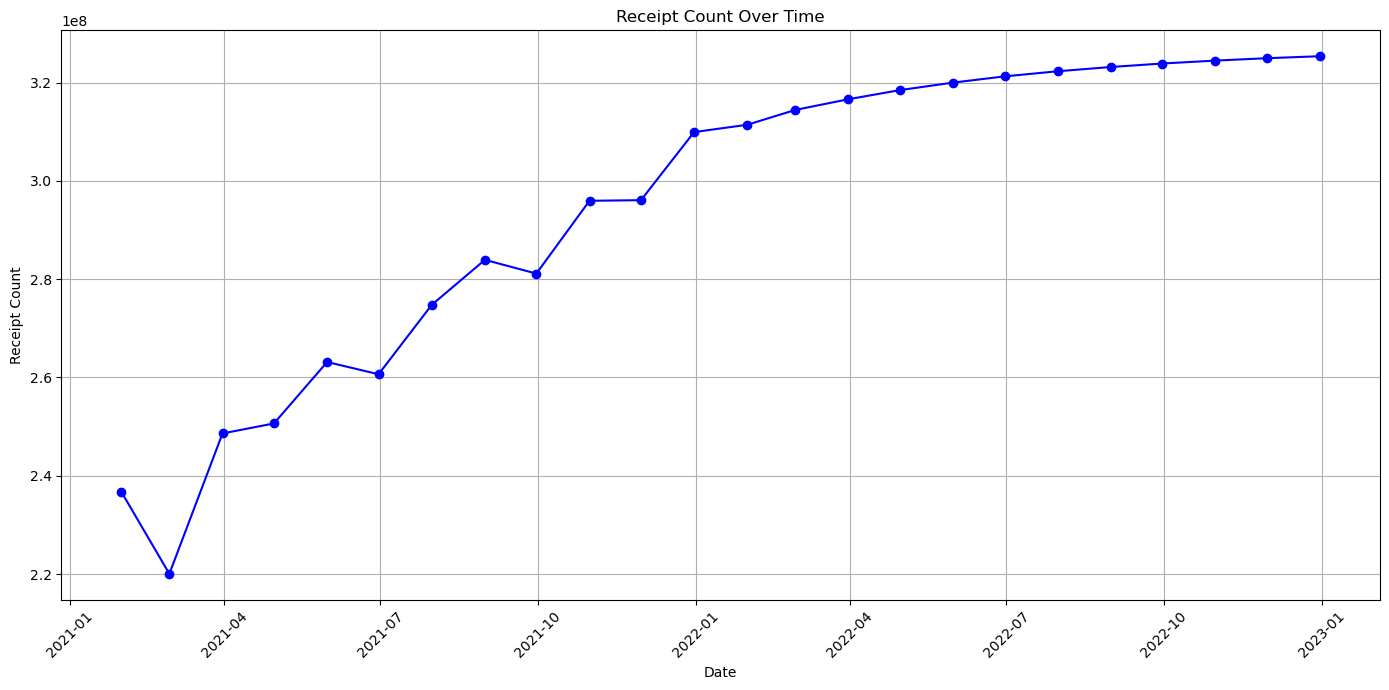

In [85]:
new_data['Date'] = pd.to_datetime(new_data['Date'])

# Plotting the corrected data
plt.figure(figsize=(14, 7))
plt.plot(new_data['Date'], new_data['Receipt_Count'], marker='o', linestyle='-', color='blue')
plt.title('Receipt Count Over Time')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

In [86]:
import pandas as pd

# Loading the data from the provided CSV file
file_path = 'data_daily.csv'
data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset to understand its structure
data.head()

,Date,Receipt_Count
0,1/1/2021,7564766
1,1/2/2021,7455524
2,1/3/2021,7095414
3,1/4/2021,7666163
4,1/5/2021,7771289


(Date             0
 Receipt_Count    0
 dtype: int64,
    Month  Receipt_Count
 0      1      236736687
 1      2      220033460
 2      3      248608625
 3      4      250644830
 4      5      263151748)

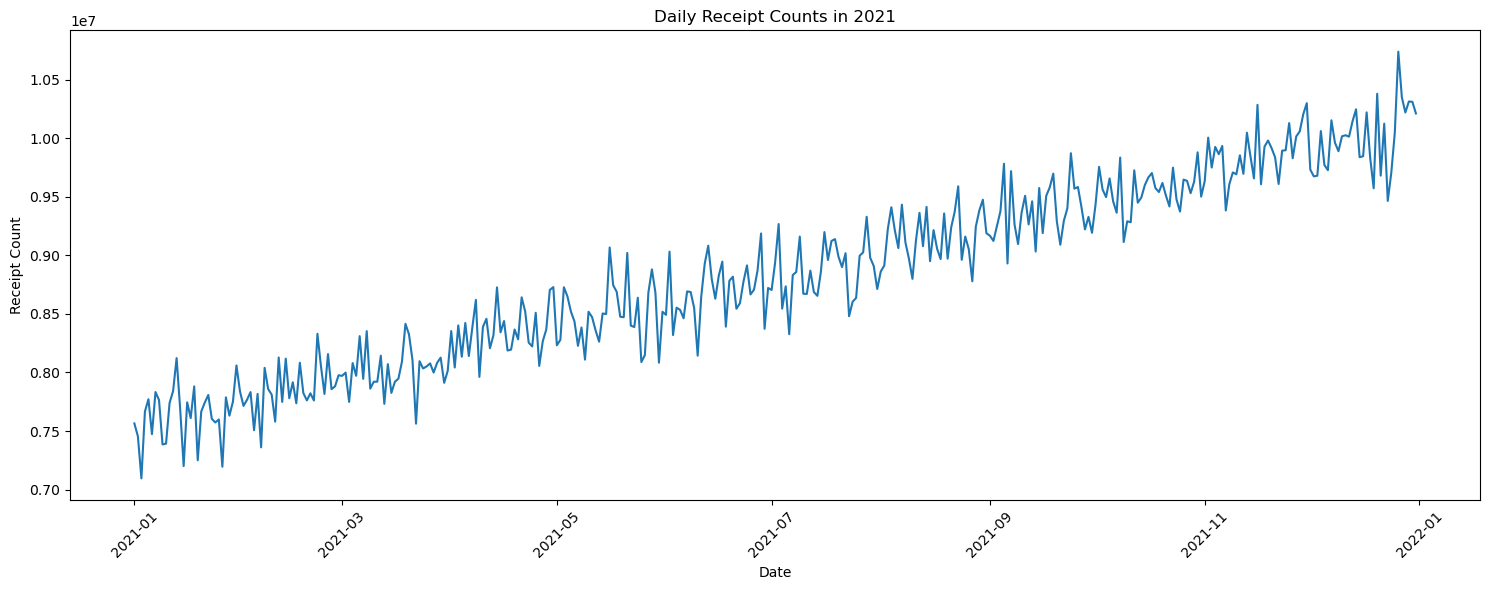

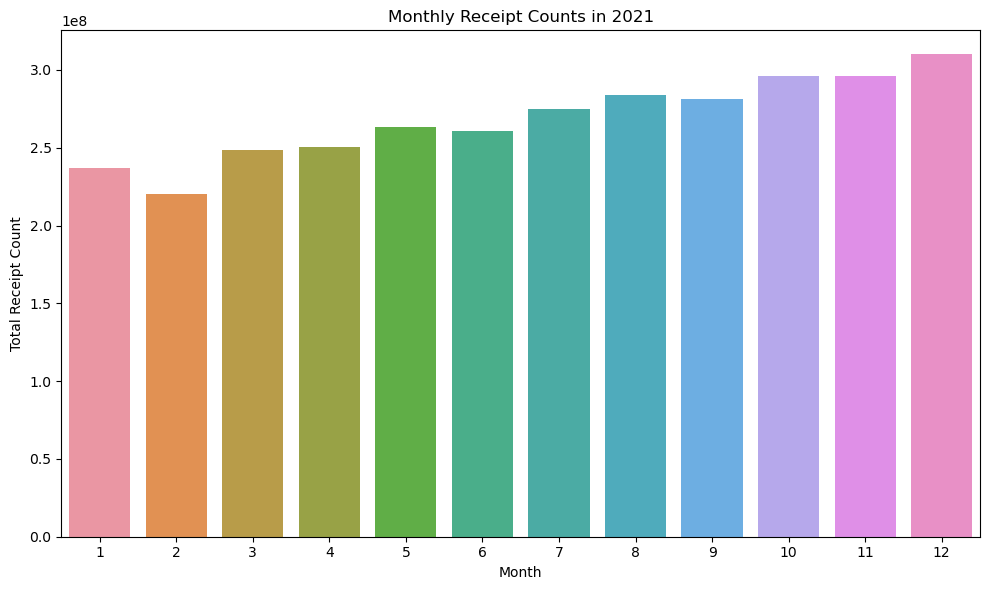

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Converting 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Checking for missing values
missing_values = data.isnull().sum()

# Feature Engineering: Extracting year, month, and day of the week
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['DayOfWeek'] = data['Date'].dt.dayofweek

# EDA: Analyzing the distribution of receipt counts
# Plotting the receipt counts over time
plt.figure(figsize=(15, 6))
sns.lineplot(x=data['Date'], y=data['Receipt_Count'])
plt.title('Daily Receipt Counts in 2021')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Summarizing receipt counts by month
monthly_receipts = data.groupby('Month')['Receipt_Count'].sum().reset_index()

# Plotting monthly receipt counts
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_receipts['Month'], y=monthly_receipts['Receipt_Count'])
plt.title('Monthly Receipt Counts in 2021')
plt.xlabel('Month')
plt.ylabel('Total Receipt Count')
plt.tight_layout()

missing_values, monthly_receipts.head()


{'ADF Statistic': 0.175044165720054, 'p-value': 0.9708266454651424}

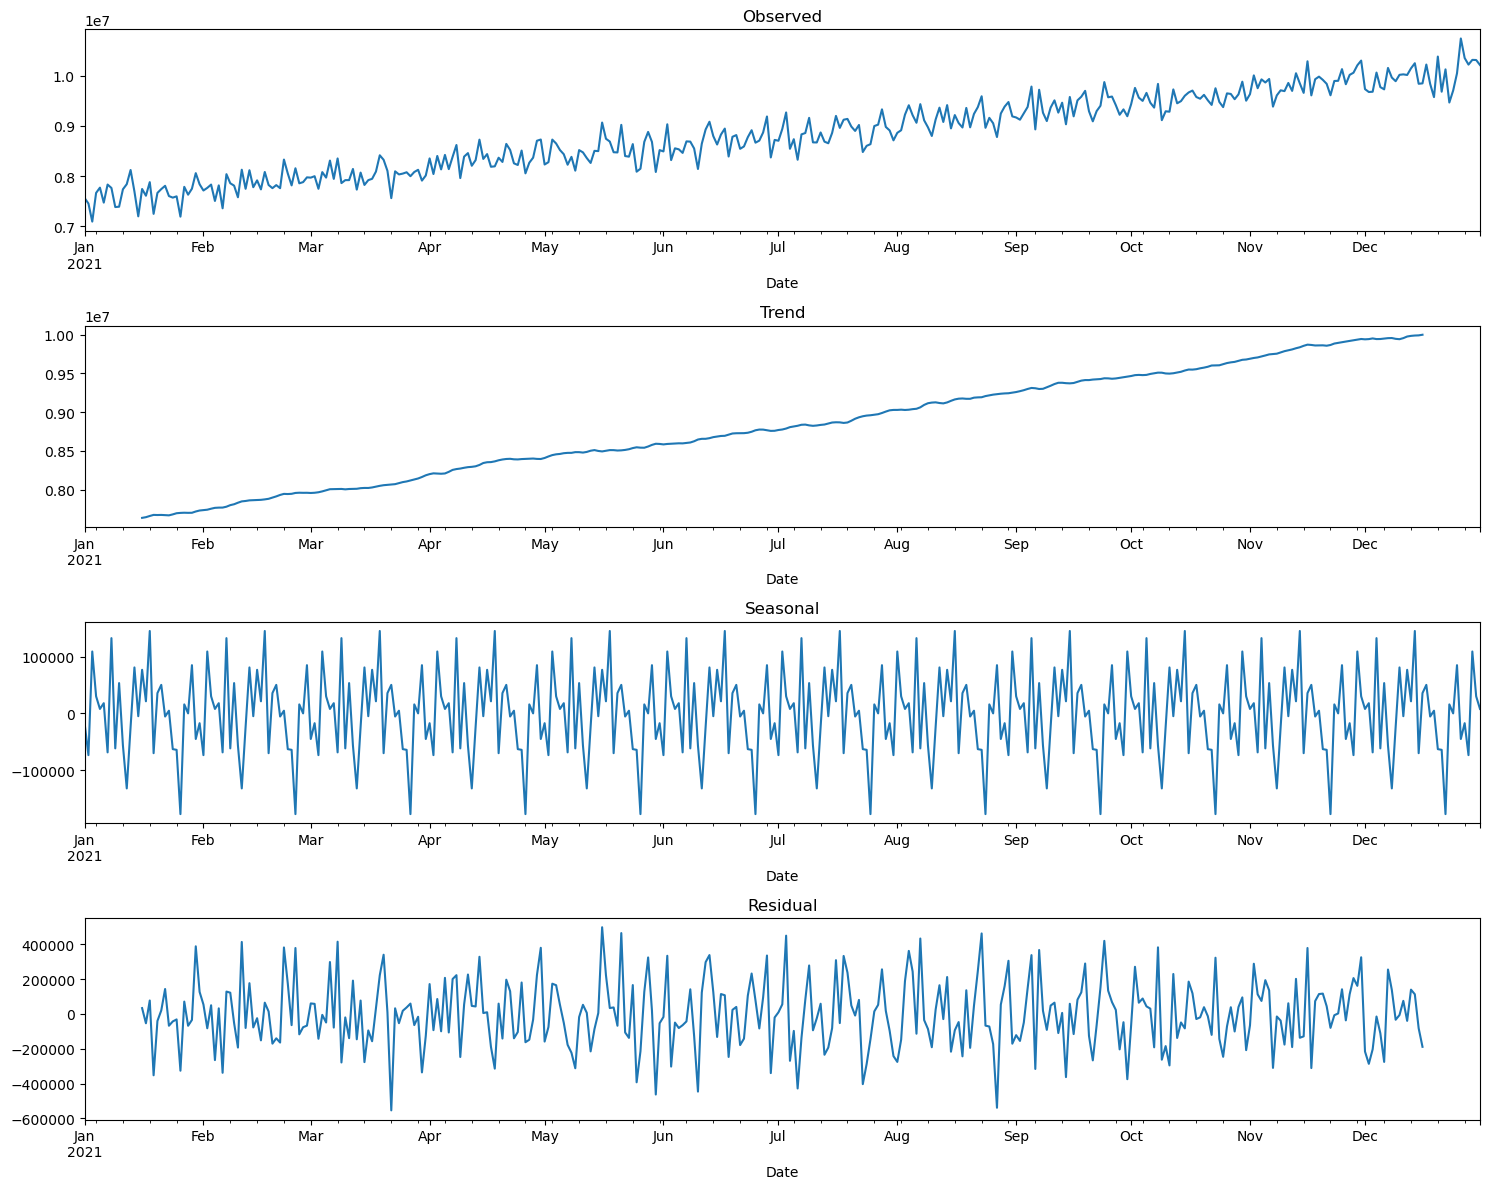

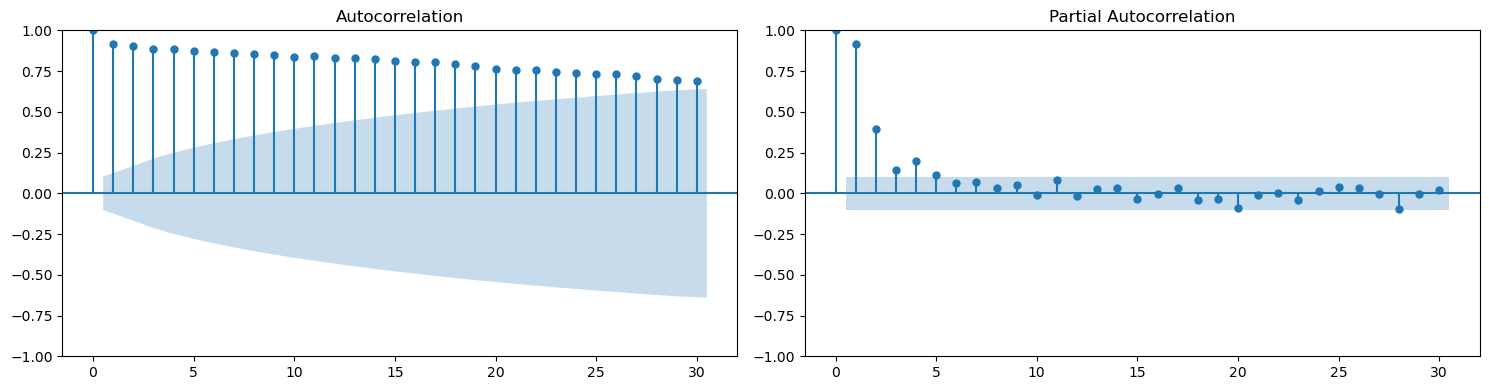

In [88]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationarity Check: Augmented Dickey-Fuller Test
adf_test = adfuller(data['Receipt_Count'])

# Seasonality Check: Seasonal Decomposition
decomposition = seasonal_decompose(data.set_index('Date')['Receipt_Count'], model='additive', period=30)

# Plotting Seasonal Decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()

# Autocorrelation and Partial Autocorrelation Analysis
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(data['Receipt_Count'], ax=ax5, lags=30)
plot_pacf(data['Receipt_Count'], ax=ax6, lags=30, method='ywm')
plt.tight_layout()

adf_test_result = {'ADF Statistic': adf_test[0], 'p-value': adf_test[1]}

adf_test_result


{'ADF Statistic': -8.889819175651194, 'p-value': 1.2512872154223906e-14}

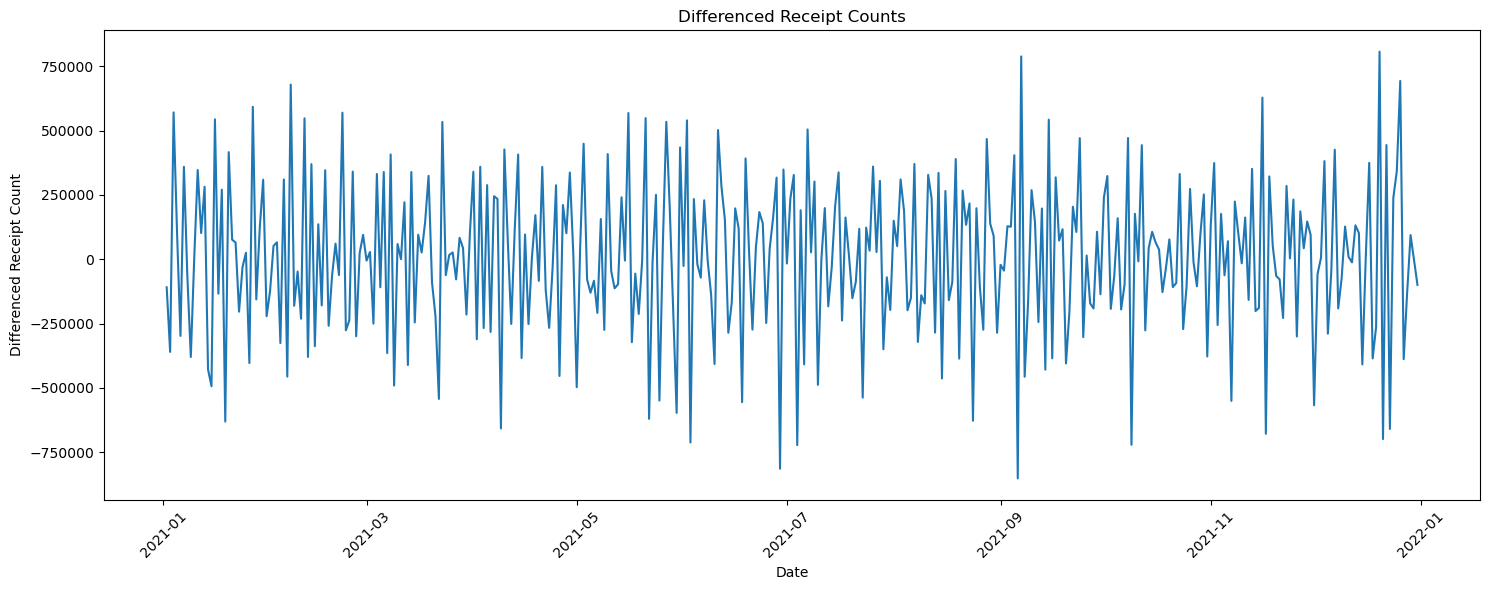

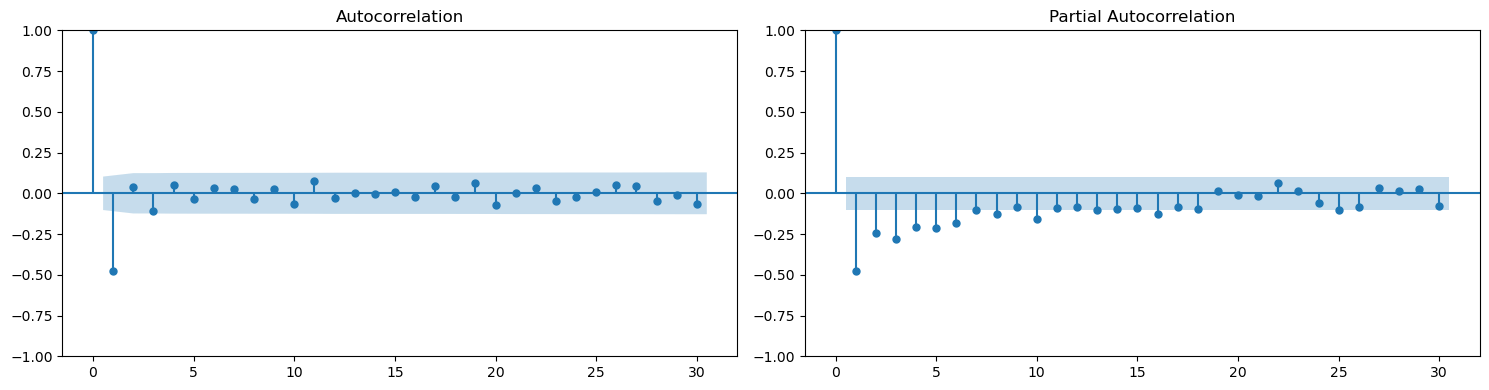

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
import numpy as np

# Differencing the data to make it stationary
data['Receipt_Count_Diff'] = data['Receipt_Count'].diff().dropna()

# Checking stationarity again after differencing
adf_test_diff = adfuller(data['Receipt_Count_Diff'].dropna())

# Plotting the differenced data
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Receipt_Count_Diff'])
plt.title('Differenced Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Differenced Receipt Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Autocorrelation and Partial Autocorrelation Analysis on differenced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(data['Receipt_Count_Diff'].dropna(), ax=ax1, lags=30)
plot_pacf(data['Receipt_Count_Diff'].dropna(), ax=ax2, lags=30, method='ywm')
plt.tight_layout()

adf_test_diff_result = {'ADF Statistic': adf_test_diff[0], 'p-value': adf_test_diff[1]}

adf_test_diff_result


In [126]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the parameter range
p, q =  range(1, 3)  

d = 1
D = 1
P = Q = range(0, 2)  # Assuming possible values of 0, 1
s = 30  # Assuming monthly seasonality

# Generate all different combinations of p, q, and q triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

best_aic = float("inf")
best_params = None

warnings.filterwarnings("ignore")  # Ignore warning messages for simplicity

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data['Receipt_Count'],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            # Compare and save the model if it has better AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)

        except Exception as e:
            continue

print(f"Best SARIMA parameters: {best_params} with AIC: {best_aic}")

Best SARIMA parameters: ((2, 1, 2), (1, 1, 1, 30)) with AIC: 8433.311522672493


In [127]:
# Identifying SARIMA Parameters
# Non-seasonal parameters
p = 2  # Lag value where PACF cuts off (after differencing)
d = 1  # Differencing order applied
q = 2  # Lag value where ACF cuts off (after differencing)

# Seasonal parameters - Assuming monthly seasonality
P = 1  # Seasonal lag value for PACF
D = 1  # Seasonal differencing might be necessary due to strong seasonality
Q = 1  # Seasonal lag value for ACF
s = 30 # Monthly seasonality

# Building the SARIMA Model
sarima_model = SARIMAX(data['Receipt_Count'], 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, s),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fitting the model
sarima_result = sarima_model.fit(disp=False)

sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Receipt_Count   No. Observations:                  365
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 30)   Log Likelihood               -4209.656
Date:                              Tue, 21 Nov 2023   AIC                           8433.312
Time:                                      17:58:44   BIC                           8459.261
Sample:                                           0   HQIC                          8443.696
                                              - 365                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9423      0.105     -9.015      0.000      -1.147      -0.737
ar.L2         -0.0288      0.103     -0.281      0.779      -0.230       0.172
ma.L1          0.2544      0.053      4.763      0.000       0.150       0.359
ma.L2         -0.6544      0.056    -11.586      0.000      -0.765      -0.544
ar.S.L30      -0.3699      0.100     -3.709      0.000      -0.565      -0.174
ma.S.L30      -0.2356      0.066     -3.575      0.000      -0.365      -0.106
sigma2        1.1e+11   5.05e-14   2.18e+24      0.000     1.1e+11     1.1e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.69   Prob(JB):                         0.90
Heteroskedasticity (H):               0.87   Skew:                            -0.01
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+41. Standard errors may be unstable.
"""

In [151]:
# Forecasting for 2022 using the SARIMA model
# The total number of days in 2022 to forecast
forecast_days = 365  # Assuming 2022 is not a leap year

# Generating the forecast
forecast = sarima_result.get_forecast(steps=forecast_days)
forecast_index = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecast': forecast_values})
forecast_df['Lower_CI'] = forecast_conf_int.iloc[:, 0]
forecast_df['Upper_CI'] = forecast_conf_int.iloc[:, 1]

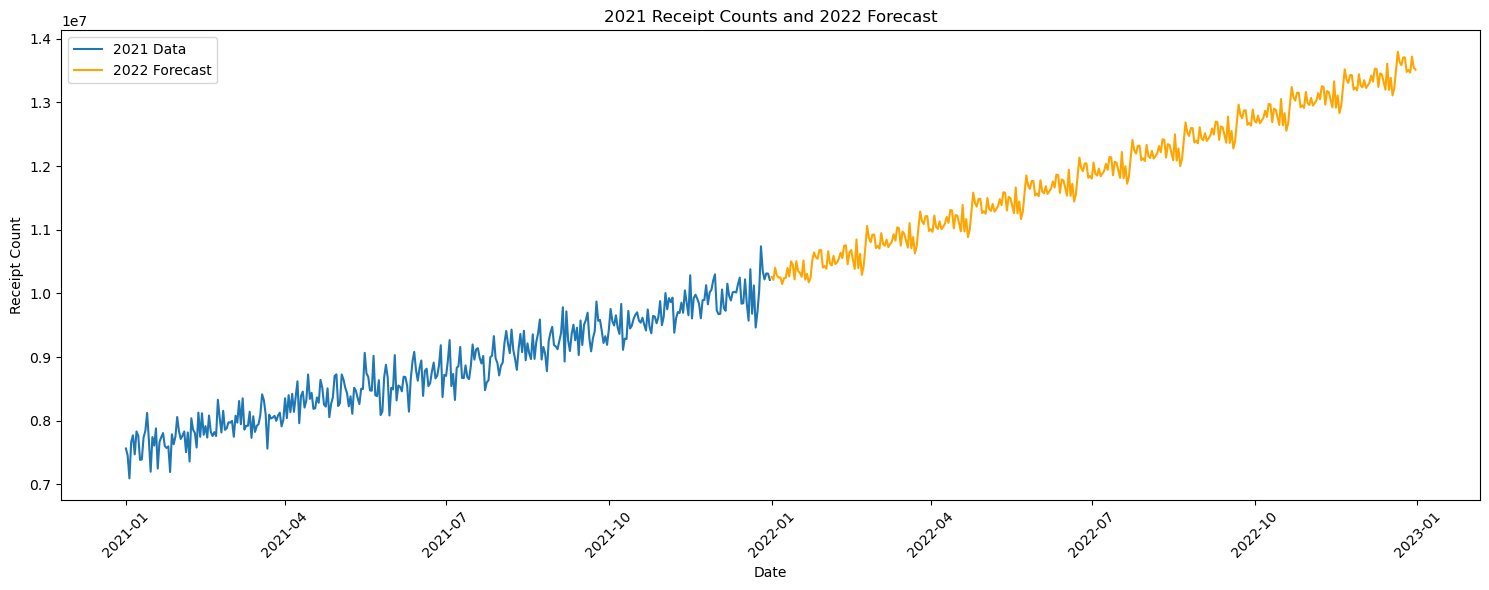

In [152]:
# Plotting the 2021 data with the 2022 forecast
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Receipt_Count'], label='2021 Data')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='2022 Forecast', color='orange')
# plt.fill_between(forecast_df['Date'], forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='k', alpha=0.15)
plt.title('2021 Receipt Counts and 2022 Forecast')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

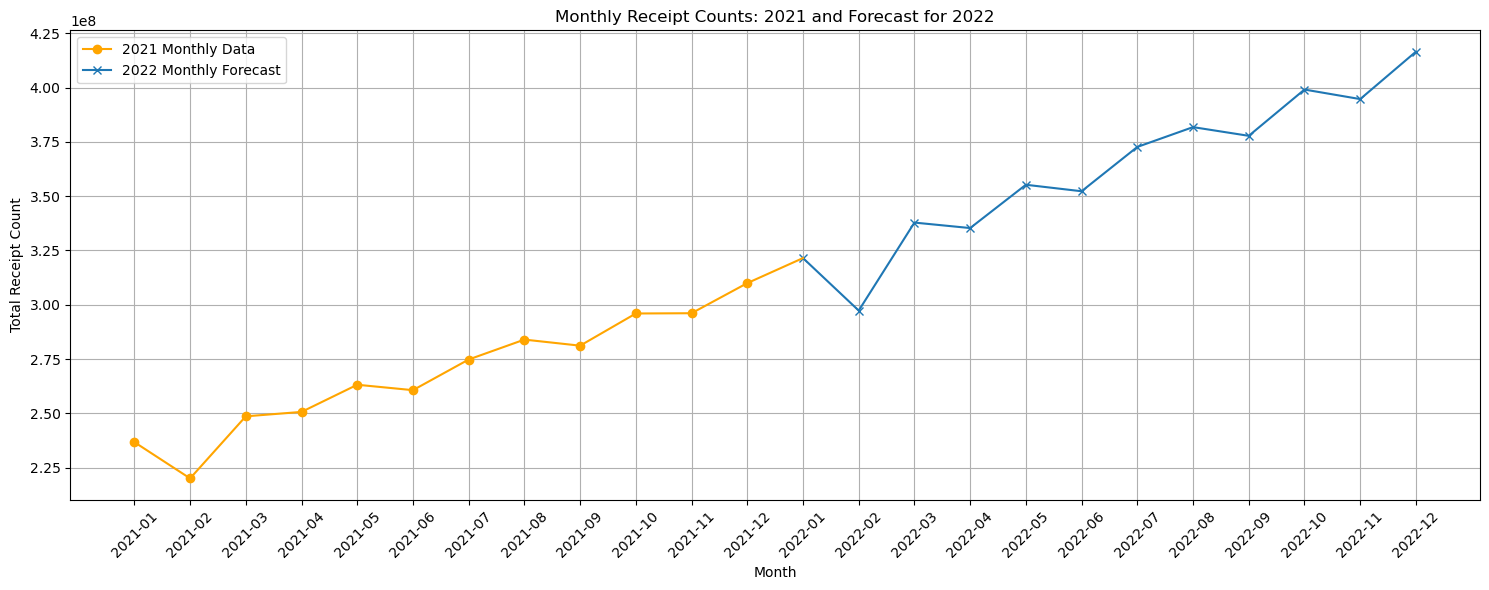

In [163]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


data['Date'] = pd.to_datetime(data['Date'])
monthly_data_2021 = data.groupby(data['Date'].dt.to_period('M')).sum().to_timestamp()
monthly_data_2021.index = monthly_data_2021.index.to_series().dt.strftime('%Y-%m')

forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
monthly_forecast_2022 = forecast_df.groupby(forecast_df['Date'].dt.to_period('M')).sum().to_timestamp()
monthly_forecast_2022.index = monthly_forecast_2022.index.to_series().dt.strftime('%Y-%m')

plt.figure(figsize=(15, 6))

# Plot 2021 data
plt.plot(monthly_data_2021.index, monthly_data_2021['Receipt_Count'], label='2021 Monthly Data', marker='o', linestyle='-', color='orange')

# Plot 2022 forecast
plt.plot(monthly_forecast_2022.index, monthly_forecast_2022['Forecast'], label='2022 Monthly Forecast', marker='x', linestyle='-')

plt.plot([monthly_data_2021.index[-1], monthly_forecast_2022.index[0]], 
         [monthly_data_2021['Receipt_Count'][-1], monthly_forecast_2022['Forecast'][0]], 
         marker='', linestyle='-', color='orange')

plt.title('Monthly Receipt Counts: 2021 and Forecast for 2022')
plt.xlabel('Month')
plt.ylabel('Total Receipt Count')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [98]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# Data scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Receipt_Count'].values.reshape(-1, 1))

# Creating the dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
9/9 [==============================] - 10s 279ms/step - loss: 0.7191 - val_loss: 0.0323
Epoch 2/50
9/9 [==============================] - 1s 68ms/step - loss: 0.0363 - val_loss: 0.0276
Epoch 3/50
9/9 [==============================] - 1s 62ms/step - loss: 0.0207 - val_loss: 0.0132
Epoch 4/50
9/9 [==============================] - 0s 52ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 5/50
9/9 [==============================] - 1s 63ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 6/50
9/9 [==============================] - 0s 51ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 7/50
9/9 [==============================] - 1s 71ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 8/50
9/9 [==============================] - 1s 68ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 9/50
9/9 [==============================] - 1s 69ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 10/50
9/9 [==============================] - 1s 71ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 11/50
9/9 [==========

In [99]:
# Assuming 'model' is your trained LSTM model and 'scaler' is the MinMaxScaler instance used for scaling the data

# Function to generate predictions using the LSTM model
def forecast(model, initial_data, steps):
    prediction_list = initial_data
    for _ in range(steps):
        x = prediction_list[-time_step:]
        x = x.reshape((1, time_step, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    return prediction_list[-steps:]

# Generating predictions for the next 365 days (assuming 2022 is not a leap year)
next_year_steps = 365
initial_data = scaled_data[-time_step:].flatten()  # Last part of 2021 data
predictions_2022_scaled = forecast(model, initial_data, next_year_steps)

# Inverse transform the predictions
predictions_2022 = scaler.inverse_transform(predictions_2022_scaled.reshape(-1, 1))

# Converting daily predictions to monthly totals for 2022
dates_2022 = pd.date_range(start='2022-01-01', periods=next_year_steps, freq='D')
monthly_totals_2022 = pd.DataFrame({'Date': dates_2022, 'Predicted_Receipts': predictions_2022.flatten()})
monthly_totals_2022 = monthly_totals_2022.groupby(monthly_totals_2022['Date'].dt.to_period('M')).sum()

# Displaying the monthly totals for 2022
print(monthly_totals_2022)

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step
         Predicted_Receipts
Date                       
2022-01        3.153507e+08
2022-02        2.858260e+08
2022-03        3.166624e+08
2022-04        3.064975e+08
2022-05        3.167256e+08
2022-06        3.065111e+08
2022-07        3.167288e+08
2022-08        3.167289e+08
2022-09        3.065119e+08
2022-10        3.167289e+08
2022-11        3.065119e+08
2022-12        3.167289e+08


C:\Users\Gliuh\AppData\Local\Temp\ipykernel_27072\1721753111.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_totals_2022 = monthly_totals_2022.groupby(monthly_totals_2022['Date'].dt.to_period('M')).sum()


In [103]:
monthly_totals_2022 = monthly_totals_2022.reset_index()
monthly_totals_2022 = pd.DataFrame(monthly_totals_2022)
monthly_totals_2022.columns = ['Date', 'Receipt_Count']
monthly_totals_2022

,Date,Receipt_Count
0,2022-01,3.153507e+08
1,2022-02,2.858260e+08
2,2022-03,3.166624e+08
3,2022-04,3.064975e+08
4,2022-05,3.167256e+08
5,2022-06,3.065111e+08
6,2022-07,3.167288e+08
7,2022-08,3.167289e+08
8,2022-09,3.065119e+08
9,2022-10,3.167289e+08


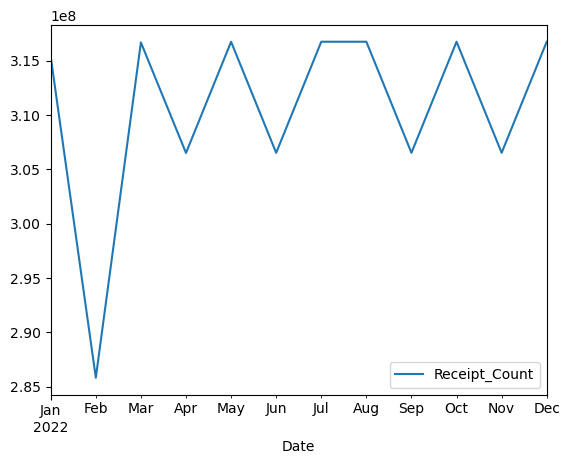

In [118]:
monthly_totals_2022.plot(x='Date', y='Receipt_Count', kind='line')
plt.show()

Text(0, 0.5, 'Receipt Count')

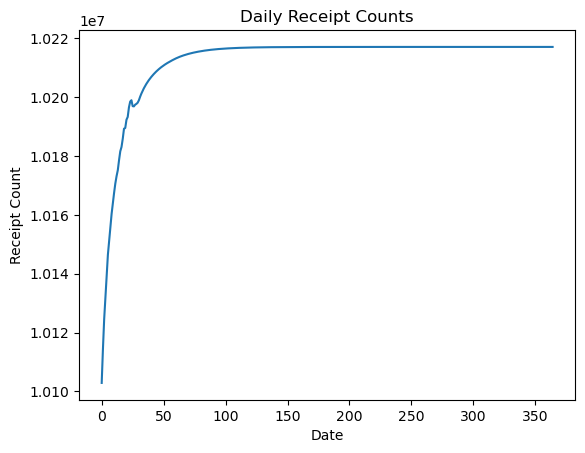

In [116]:
plt.plot(predictions_2022)
plt.title('Daily Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Receipt Count')

In [122]:
pip install transformer 

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
